In [1]:
from collections import Counter
import string
import re
import argparse
import json
import sys
import numpy as np
import nltk
import random
import math
import os
import pickle
from tqdm import tqdm
import seaborn as sns
import pandas as pd

In [2]:
in_pkl_path = "./"
pred_pkl_name = "h2_predictions_no_tf.pkl"
gt_pkl_name = "../data/coqa/preprocessed_dev_no_tf.pkl"

In [3]:
def pickler(path,pkl_name,obj):
    with open(os.path.join(path, pkl_name), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def unpickler(path,pkl_name):
    with open(os.path.join(path, pkl_name) ,'rb') as f:
        obj = pickle.load(f)
    return obj

In [4]:
dev_data = unpickler(in_pkl_path,gt_pkl_name)

In [5]:
dev_data.keys()

dict_keys(['passages_word', 'passages_char', 'questions_word', 'questions_char', 'answers_word', 'answers_char', 'histories_word', 'histories_char', 'supporting_facts', 'unpadded_question_lengths', 'unpadded_passage_lengths', 'unpadded_answer_lengths', 'data_points', 'turn_ids', 'questions_word_unpadded', 'questions_char_unpadded', 'separator_id'])

In [6]:
len(dev_data['supporting_facts'][100])

25

In [7]:
gt = dev_data["supporting_facts"]

In [8]:
len(gt)

7983

In [9]:
gt_classes = np.array(gt).argmax(axis=1)

In [10]:
gt_classes[:15]

array([ 0,  0,  2,  3,  6,  7,  9,  9, 10, 15, 17, 14,  0,  4,  8])

In [11]:
gt_classes.shape

(7983,)

In [12]:
predictions = unpickler(in_pkl_path,pred_pkl_name)

In [13]:
predictions.shape

(7983, 25)

In [14]:
predictions[0]

array([  9.144161  ,   3.9989572 ,   1.872393  ,  -2.0716138 ,
         2.0560553 ,   1.5932986 ,   1.8990226 ,  -0.23107328,
        -3.9870133 ,   3.1387224 ,  -5.2471266 ,  -0.4208253 ,
        -5.289769  ,   1.4661468 ,  -5.276964  ,   0.24363959,
        -1.1225045 ,  -1.3411887 ,  -3.8600721 ,  -1.3728303 ,
       -12.418071  , -13.563217  , -13.914795  , -13.199489  ,
       -11.924395  ], dtype=float32)

In [15]:
#Sorting in decending order of scores
predictions_arg_sorted = (-predictions).argsort()

In [16]:
predictions_arg_sorted.shape

(7983, 25)

In [17]:
predictions_arg_sorted[0]

array([ 0,  1,  9,  4,  6,  2,  5, 13, 15,  7, 11, 16, 17, 19,  3, 18,  8,
       10, 14, 12, 24, 20, 23, 21, 22])

Avg number of sentences per passage in coqa = 15

In [18]:
print(min(dev_data['turn_ids']))
print(max(dev_data['turn_ids']))

1
25


Turn IDs start from 1. Convert them to 0 based by subtracting 1 to save pain later

In [19]:
zero_based_turn_id = [t-1 for t in dev_data['turn_ids']]

In [20]:
print(min(zero_based_turn_id))
print(max(zero_based_turn_id))

0
24


In [21]:
turn_id_buckets = [[] for i in range(max(zero_based_turn_id) + 1)]

In [22]:
len(turn_id_buckets)

25

Segregate data indices into buckets based on turn ID

In [23]:
for i,t_id in enumerate(zero_based_turn_id):
    turn_id_buckets[t_id].append(i)

## Turn_ID vs number of questions

In [24]:
turn_vs_count_df = pd.DataFrame(data={"Turn_ID":list(range(max(zero_based_turn_id) + 1)), 
                                      "Number_of_questions":[len(x) for x in turn_id_buckets]})

In [25]:
turn_vs_count_df.head()

,Turn_ID,Number_of_questions
0,0,500
1,1,500
2,2,500
3,3,500
4,4,500


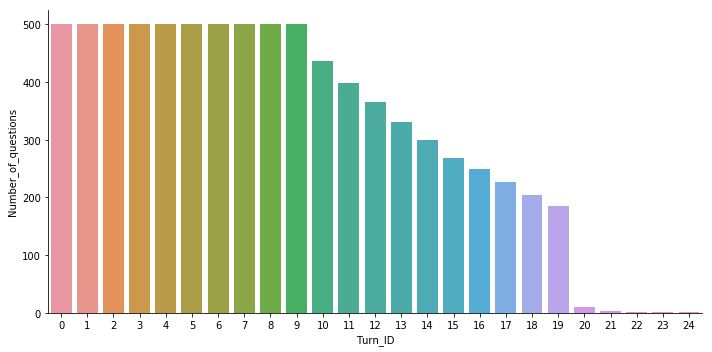

In [26]:
sns.catplot(x="Turn_ID", y="Number_of_questions", kind='bar', data=turn_vs_count_df, height=5, aspect=2)

## Turn_ID vs Accuracy

In [27]:
turn_vs_accuracy = []
for bucket in turn_id_buckets:
    num_correct = 0
    bucket_size = len(bucket)
    for data_index in bucket:
        if(predictions_arg_sorted[data_index][0] == gt_classes[data_index]):
            num_correct += 1
    turn_vs_accuracy.append(num_correct/bucket_size)

In [28]:
turn_vs_accuracy_df = pd.DataFrame(data={"Turn_ID":list(range(max(zero_based_turn_id) + 1)), 
                                      "Accuracy":turn_vs_accuracy})

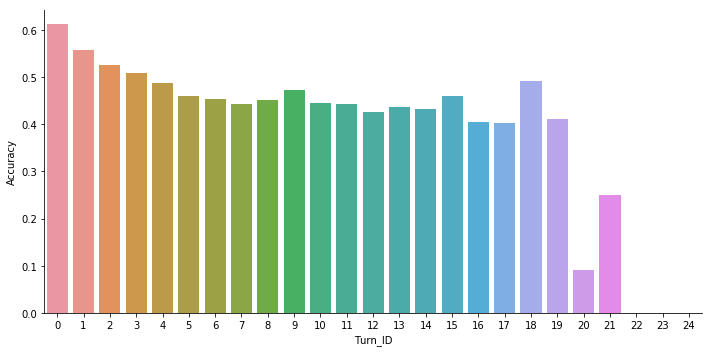

In [29]:
sns.catplot(x="Turn_ID", y="Accuracy", kind='bar', data=turn_vs_accuracy_df, height=5, aspect=2)

## Turn_ID vs answer ranks

In [30]:
answer_ranks = []
for i,gt in enumerate(gt_classes):
    rank = predictions_arg_sorted[i].tolist().index(gt)
    answer_ranks.append(rank)
assert(len(answer_ranks) == len(zero_based_turn_id))

In [31]:
turn_vs_ans_rank_df = pd.DataFrame(data={"Turn_ID":zero_based_turn_id, "Answer_rank":answer_ranks})

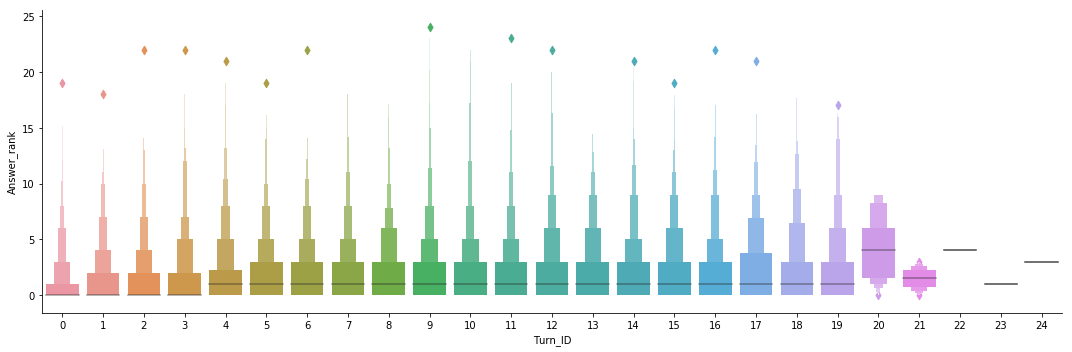

In [32]:
sns.catplot(x="Turn_ID", y="Answer_rank", kind='boxen', data=turn_vs_ans_rank_df, height=5, aspect=3)

## Turd_ID vs mean answer rank

In [33]:
mean_ans_ranks = []
for bucket in turn_id_buckets:
    ranks = []
    for data_index in bucket:
        ranks.append(answer_ranks[data_index])
    mean_rank = np.array(ranks).mean()
    mean_ans_ranks.append(mean_rank)

In [34]:
turn_vs_mean_ans_rank_df = pd.DataFrame(data={"Turn_ID":list(range(max(zero_based_turn_id) + 1)), "Mean_answer_rank":mean_ans_ranks})

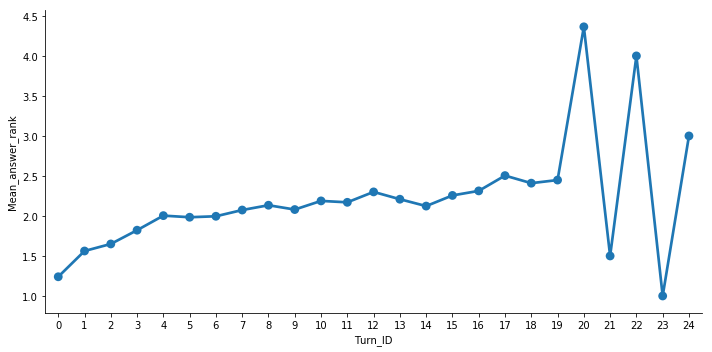

In [35]:
sns.catplot(x="Turn_ID", y="Mean_answer_rank", kind='point', data=turn_vs_mean_ans_rank_df, height=5, aspect=2)

Vertical lines = confidence intervals (0.95)

/home/bhargav/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


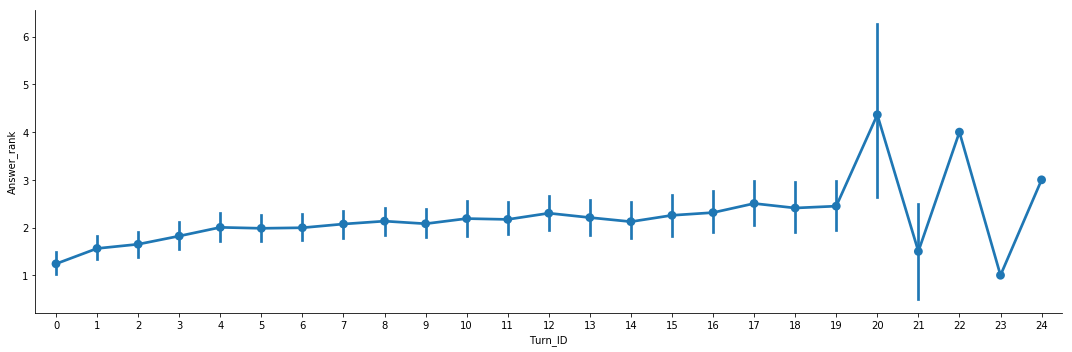

In [36]:
sns.catplot(x="Turn_ID", y="Answer_rank", kind='point', data=turn_vs_ans_rank_df, height=5, aspect=3)

Vertical lines = standard deviation

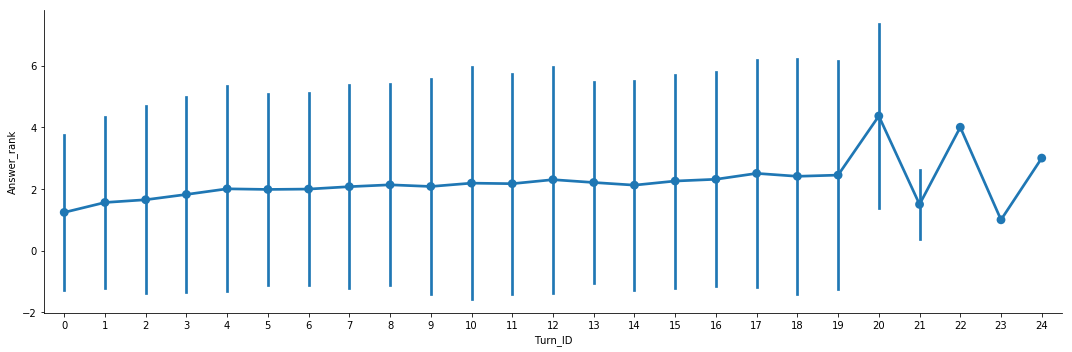

In [37]:
sns.catplot(x="Turn_ID", y="Answer_rank", kind='point', data=turn_vs_ans_rank_df, height=5, aspect=3, ci='sd')

In [38]:
grouped_ranks = []
for rank in answer_ranks:
    cat = "Other"
    if(rank == 0):
        cat = "0"
    elif(rank == 1):
        cat = "1"
    elif(rank == 2):
        cat = "2"
    elif(rank == 3):
        cat = "3"
    grouped_ranks.append(cat)

In [116]:
turn_vs_rank_cat = [[] for i in range(max(zero_based_turn_id) + 1)]
for i,rank in enumerate(grouped_ranks):
    turn_id = zero_based_turn_id[i]
    turn_vs_rank_cat[turn_id].append(rank)
    

In [121]:
t_ids = []
rank_categories = []
fractions = []
for i,bucket in enumerate(turn_vs_rank_cat):
    unique, counts = np.unique(bucket, return_counts=True)
    frac = dict(zip(unique, counts/len(bucket)))
#     print("==============")
#     print(i,frac)
#     print("==============")
    for key,value in frac.items():
        t_ids.append(i)
        rank_categories.append(key)
        fractions.append(value)
        
assert(len(t_ids) == len(rank_categories) == len(fractions))

In [124]:
print(t_ids[:10])
print(rank_categories[:10])
print(fractions[:10])

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
['0', '1', '2', '3', 'Other', '0', '1', '2', '3', 'Other']
[0.612, 0.152, 0.088, 0.036, 0.112, 0.558, 0.15, 0.084, 0.052, 0.156]


In [126]:
turn_vs_rank_cat_df = pd.DataFrame(data={'Turn_ID':t_ids, 'Rank_categories':rank_categories, 'Fractions':fractions})

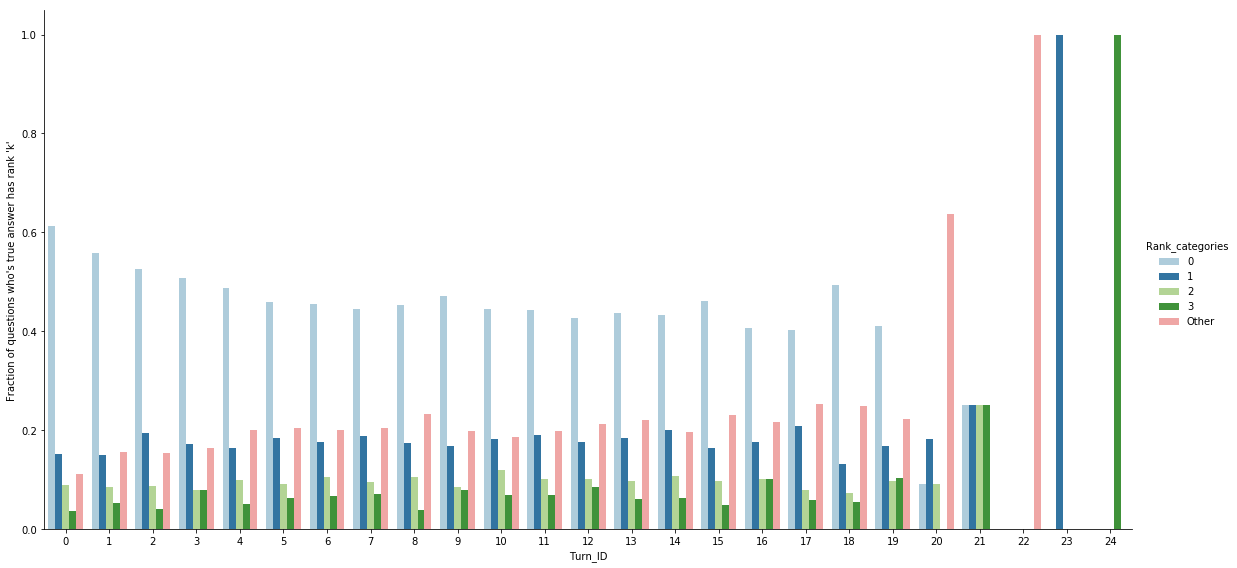

In [136]:
p = sns.catplot(x="Turn_ID", y="Fractions", hue="Rank_categories", data=turn_vs_rank_cat_df,
                height=8, aspect=2, kind="bar", palette="Paired", hue_order=['0','1','2','3','Other'])
p.set_ylabels("Fraction of questions who's true answer has rank 'k'")